<h3>Using ResNET-50 for binary classification of images as real/fake</h3>
with PyTorch


PARAMETERS:
1. batchsize = 30<br>
2. learningrate = 0.00001<br>
3. Optimizer = SGD (Stochastic Gradient Descent)<br>
4. momentum = 0.9<br>
5. Loss Function = Cross Entropy Loss<br>
6. Resized Resolution = 256 x 256<br>
7. epochs = 150<br>

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder
from torchsummary import summary  # Optional, for model summary

In [2]:
# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=10),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the parent directory containing class folders
data_dir = os.path.join(os.getcwd(), "biggan")

# Create ImageFolder dataset
dataset = ImageFolder(root=data_dir, transform=transform)

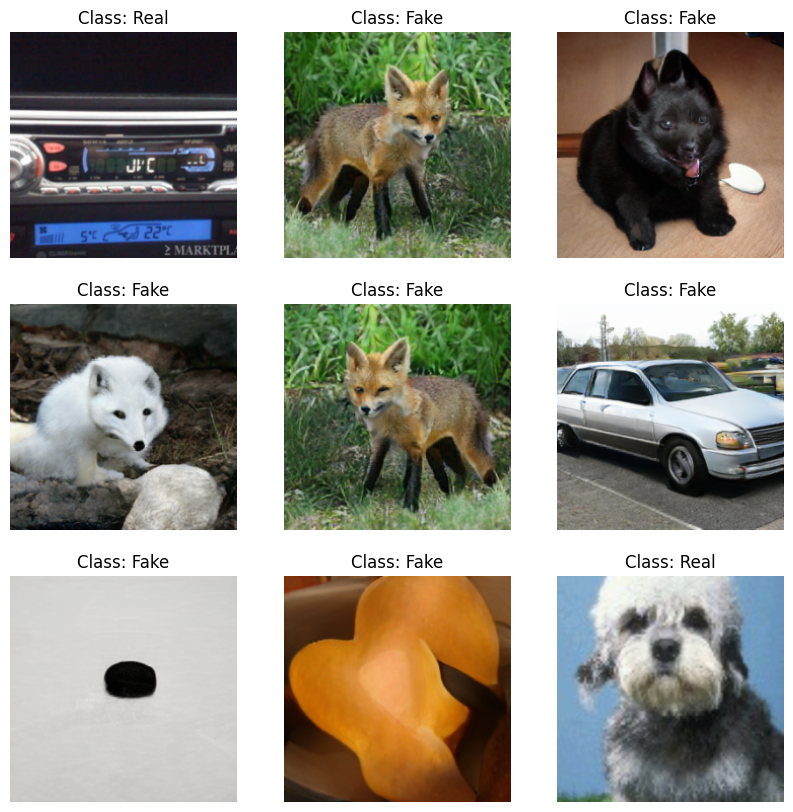

In [4]:
# Visualize 9 random samples
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        random_index = np.random.randint(len(dataset))
        img, label = dataset[random_index]
        img = img.numpy().transpose((1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]
        
        if label == 1: label = 'Fake'
        if label == 0: label = 'Real'
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'Class: {label}')
        axes[i, j].axis('off')

plt.show()

In [5]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [7]:
# Load pre-trained ResNet-18 model
base_model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
num_features = base_model.fc.in_features

# Freeze the parameters of the pre-trained layers
for param in base_model.parameters():
    param.requires_grad = False

In [8]:
# Modify the last fully connected layer for binary classification
base_model.fc = nn.Linear(num_features, 2)  # 2 classes for binary classification

In [9]:
# Move the model to the device
base_model = base_model.to(device)

In [10]:
# Optional: Print the summary of the model
summary(base_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer = SGD(base_model.parameters(), lr=learning_rate, momentum=0.9)

# Optional: Add learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = None

<h3>Train the Model</h3>

In [12]:
# Lists to store the training history for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    base_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    x = 1
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(x)
        x+=1

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation loop
    base_model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = base_model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Append values to the history lists for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)

    # Print and visualize progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Optional: Adjust learning rate
    if scheduler is not None:
        scheduler.step()

1
2
3
4


: 

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()